In [85]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [165]:
# Dataset de exemplo
adm = pd.read_csv('Admission_Predict_Ver1.1.csv', header=0, index_col=0)

# Retira espacos dos nomes das colunas
lista_colunas = []
for c in adm.columns:
    c = c.replace(' ', '')
    lista_colunas.append(c)
adm.columns = lista_colunas

# Cria nova coluna target (Classe)
mask = adm['ChanceofAdmit'] >= 0.80 # Sera True se ChanceofAdmit maior que 80%
adm['Classe'] = 1 * mask  # Para transformar a mascara em inteiro (0=False ou 1=True)
adm.head()

,GREScore,TOEFLScore,UniversityRating,SOP,LOR,CGPA,Research,ChanceofAdmit,Classe
Serial No.,,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92,1
2,324,107,4,4.0,4.5,8.87,1,0.76,0
3,316,104,3,3.0,3.5,8.00,1,0.72,0
4,322,110,3,3.5,2.5,8.67,1,0.80,1
5,314,103,2,2.0,3.0,8.21,0,0.65,0


In [166]:
# Determina variaveis independentes (X) e variavel dependente (y)
X = adm.loc[:,'GREScore':'Research']
y = adm.loc[:,'Classe']

In [167]:
# Monta 4 sets de X para comparacao:
X_Original = pd.DataFrame(data=X, index=X.index, columns=X.columns)
X_Scaled = pd.DataFrame(data=scale(X), index=X.index, columns=X.columns)
X_RobustScaled = pd.DataFrame(data=robust_scale(X), index=X.index, columns=X.columns)
X_Normalized = pd.DataFrame(data=normalize(X), index=X.index, columns=X.columns)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


In [168]:
# Monta um DataFrame com o valor minimo, mediana e maximo de cada feature
Xs = {'Original': X_Original, 'Scaled': X_Scaled, 'RobustScaled': X_RobustScaled, 'Normalized': X_Normalized}
values = []
for x in Xs:
    for c in Xs[x].columns:
        values.append([x, c, Xs[x][c].min(), Xs[x][c].median(), Xs[x][c].max()])
df = pd.DataFrame(data=values, columns=['Set', 'Feature', 'Min', 'Median', 'Max'])
df

,Set,Feature,Min,Median,Max
0,Original,GREScore,290.000000,317.000000,340.000000
1,Original,TOEFLScore,92.000000,107.000000,120.000000
2,Original,UniversityRating,1.000000,3.000000,5.000000
3,Original,SOP,1.000000,3.500000,5.000000
4,Original,LOR,1.000000,3.500000,5.000000
5,Original,CGPA,6.800000,8.560000,9.920000
6,Original,Research,0.000000,1.000000,1.000000
7,Scaled,GREScore,-2.346008,0.046793,2.085104
8,Scaled,TOEFLScore,-2.500419,-0.031601,2.108041
9,Scaled,UniversityRating,-1.850542,-0.099793,1.650957


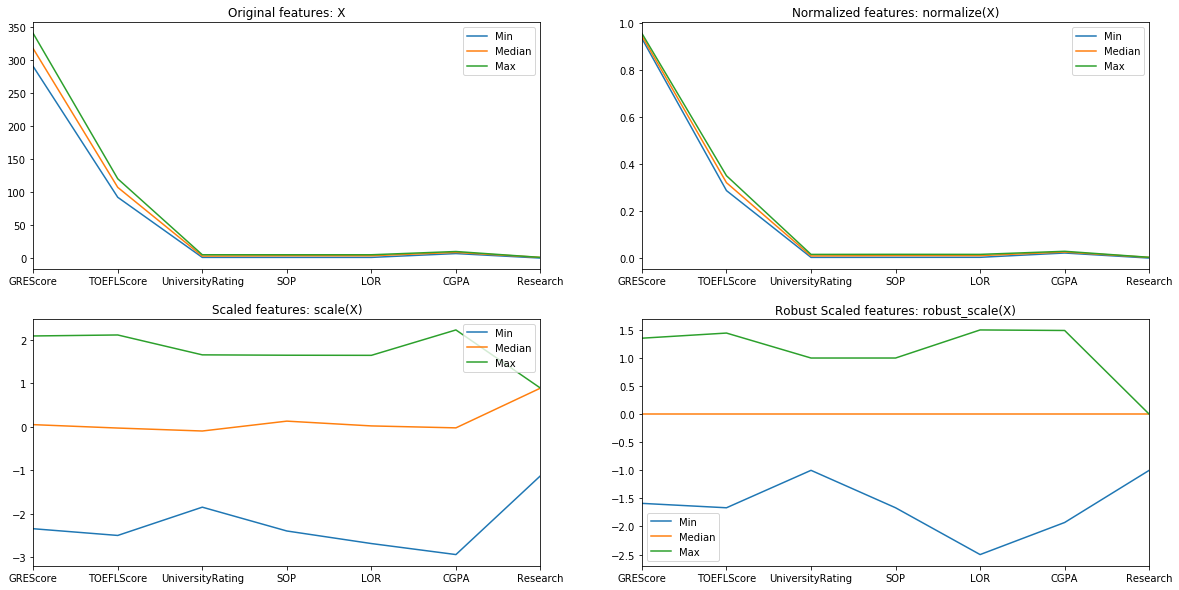

In [170]:
# Compara os resultados para cada dataset de X
# Note que a normalizacao manteve a discrepancia da primeira feature em relacao as demais,
# enquanto que os metodos scale e robust_scale corrigiram esta discrepancia
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(20, 10)
plt.setp(ax, xticklabels=['GREScore', 'TOEFLScore', 'UniversityRating', 'SOP', 'LOR', 'CGPA', 'Research'])
df[df['Set'] == 'Original'].plot(kind='line', title='Original features: X', ax=ax[0][0])
df[df['Set'] == 'Normalized'].plot(kind='line', title='Normalized features: normalize(X)', ax=ax[0][1])
df[df['Set'] == 'Scaled'].plot(kind='line', title='Scaled features: scale(X)', ax=ax[1][0])
df[df['Set'] == 'RobustScaled'].plot(kind='line', title='Robust Scaled features: robust_scale(X)', ax=ax[1][1])

In [174]:
# Comparando a precisao (accuracy_score) de cada dataset, usando o mesmo estimador (SVC)
# Note que, neste caso, a maior precisao eh obtida com o metodo scale(X):
Xs = {'Original': X_Original, 'Normalized': X_Normalized, 'Scaled': X_Scaled, 'Robust Scaled': X_RobustScaled}
svm = SVC(gamma='auto')
for a in Xs:
    # random_state = 0 para selecionar os mesmos dados de teste
    # para todos os datasets (para permitir a comparacao)
    X_train, X_test, y_train, y_test = train_test_split(Xs[a], y, random_state=0)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    print (a, accuracy_score(y_test, y_pred))

Original 0.92
Normalized 0.728
Scaled 0.944
Robust Scaled 0.936
